# Lab - Dogs vs Cats

Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.

I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

## Uppgifter
Dokumentera i markdown i Jupyter notebook eller i separat markdownfil om du använder Pythonskript.

## 0. EDA och filhantering (*)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

!pip3 install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 KB 976.7 kB/s eta 0:00:0000:0100:01


### c) Skapa folderstrukturen med Python

I started with manually removing the extra train and test folder, since these just created an unnecessary long file path. 

In [ ]:
#for size in ["small", "tiny"]:
#    os.mkdir(f"experiment_{size}_data")
#    for dataset in ["test", "train", "val"]:
#        os.mkdir(f"experiment_{size}_data/{dataset}")

#os.rename("Pictures_of_dogs_and_cats", "original_data")

### a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.

### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [ ]:
def plot_random_sample(number_of_samples:int) -> None:
    """
    Plots a random sample of images from the original Dogs vs Cats data.
    Plots five images per row.
    
    Parameters
    ----------
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows are filled.
        
    Returns
    -------
    None
    """

    # Initialises variables
    labels = [random.choice(["cat", "dog"]) for i in range(number_of_samples)]
    numbers = random.sample(range(12500), number_of_samples)
    images = []

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)

    # Reads the images and saves the labels
    for label, number in zip(labels, numbers):
        images.append(plt.imread(f"original_data/train/{label}.{number}.jpg"))
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    for i, ax, label in zip(range(number_of_samples), axes.flatten(), labels):
        ax.imshow(images[i]) 
        ax.axis("off")
        if label == "cat":
            ax.set(title="Cat: 0")
        else:
            ax.set(title="Dog: 1")

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

In [ ]:
#plot_random_sample(10)

### d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.

Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)

In [ ]:
# Saves all file names in the original data in a dataframe
#img_names = pd.DataFrame({"file_name" : os.listdir("original_data/train")})

# Creates cat column with True if the file name contains cat and False if the file name contains dog
#img_names["cat"] = img_names["file_name"].str.contains("cat") 

#cats = img_names[img_names["cat"] == True]
#dogs = img_names[img_names["cat"] == False]
#len(cats), len(dogs)

In [ ]:
def train_val_test_split(data1:pd.Series, data2:pd.Series, train_size:int, val_size:int, test_size:int) -> tuple:
    """
    Creates equally sized, random samples from two datasets,
    and splits them into training, validation and test data. 
    
    Parameters
    ----------
    data1 : pd.Series
        The file names in dataset 1
    data2 : pd.Series
        The file names in dataset 2
    train_size : int
        Size of training data 
    val_size : int
        Size of validation data 
    test_size : int
        Size of test data 
    
    Returns
    -------
    train, val, test : tuple[list, list, list]:
        A tuple of training, validation and test data 
    """

    # Half size for each dataset
    train_size = int(train_size/2)
    val_size = int(val_size/2)
    test_size = int(test_size/2)

    # Picks out a full sample 
    full_sample_size = train_size + val_size + test_size
    data1_full_sample = random.sample(list(data1), full_sample_size)
    data2_full_sample = random.sample(list(data2), full_sample_size)

    # Creates random training sample from the full sample and merge dataset 1 and 2
    data1_train = random.sample(data1_full_sample, train_size)
    data2_train = random.sample(data2_full_sample, train_size)
    train = data1_train + data2_train

    # Creates random validation sample from the data not used for training  and merge dataset 1 and 2
    data1_val = random.sample(list(set(data1_full_sample) - set(data1_train)), val_size) #Reference: https://stackoverflow.com/questions/41125909/python-find-elements-in-one-list-that-are-not-in-the-other
    data2_val = random.sample(list(set(data2_full_sample) - set(data2_train)), val_size)
    val = data1_val + data2_val

    # Creates random test sample from the data not used for training or validation and merge dataset 1 and 2
    data1_test = random.sample(list(set(data1_full_sample) - set(data1_train) - set(data1_val)), test_size)
    data2_test = random.sample(list(set(data2_full_sample) - set(data2_train) - set(data2_val)), test_size)
    test = data1_test + data2_test

    return train, val, test

In [ ]:
#train_small, val_small, test_small = train_val_test_split(cats["file_name"], dogs["file_name"], 1600, 400, 500)
#train_tiny, val_tiny, test_tiny = train_val_test_split(cats["file_name"], dogs["file_name"], 160, 40, 50)

In [ ]:
#print(f"{len(set(train_small))} out of a total of {len(train_small)} training samples are unique.")
#print(f"{len(set(val_small))} out of a total of {len(val_small)} validation samples are unique.")
#print(f"{len(set(test_small))} out of a total of {len(test_small)} test samples are unique.")

#print(f"Any image both in validation and training data? {any(sample in val_small for sample in train_small)}")
#print(f"Any image both in test and training data? {any(sample in test_small for sample in train_small)}")
#print(f"Any image both in validation and test data? {any(sample in val_small for sample in test_small)}")

In [ ]:
#for data, folder in zip([train_tiny, val_tiny, test_tiny], ["train", "val", "test"]):
    
#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_tiny_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

In [ ]:
#for data, folder in zip([train_small, val_small, test_small], ["train", "val", "test"]):

#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_small_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

### e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

plotta några bilder med deras respektive labels och kontrollera att det är korrekt.

In [3]:
def read_images(folder_path:str) -> tuple:
    """
    Reads all images in the specified folder and extracts the label. 
    
    Parameters
    ----------
    folder_path : str
        The folder path from which to read the images.
    
    Returns
    -------
    data, labels : tuple[np.ndarray, np.ndarray]:
        A tuple of X and y data. 
    """

    data = []
    labels = []
    img_names = os.listdir(folder_path)

    # Reads the images
    for file in img_names:
        data.append(plt.imread(f"{folder_path}/{file}"))
    data = np.asarray(data, dtype=object)

    # Extract labels
    for img_name in img_names:
        if "cat" in img_name:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels)

    # Shuffle the data
    np.random.seed(42)
    np.random.shuffle(data)
    np.random.seed(42)
    np.random.shuffle(labels)

    return data, labels

In [ ]:
#X_train_small, y_train_small = read_images("experiment_small_data/train")
#X_val_small, y_val_small  = read_images("experiment_small_data/val")
#X_test_small, y_test_small = read_images("experiment_small_data/test")

#X_train_tiny, y_train_tiny = read_images("experiment_tiny_data/train")
#X_val_tiny, y_val_tiny = read_images("experiment_tiny_data/val")
#X_test_tiny, y_test_tiny = read_images("experiment_tiny_data/test")

In [2]:
def plot_images(X:np.ndarray, y:np.ndarray, number_of_samples:int, start_index:int=0, random_sample:bool=False) -> None:
    """
    Plots five images per row. 
    
    Parameters
    ----------
    X : np.ndarray
        An array of images
    y : np.ndarray
        An array of labels
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows are filled.
    start_index : int
        The index of the image to start with (default 0)
    random_sample : bool
        If True, plots a random sample (default False)
        
    Returns
    -------
    None
    """

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    if random_sample == True:
        sample = random.sample(range(len(X)), number_of_samples)
        for i, ax in zip(sample, axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])        
    else:
        for i, ax in zip(range(start_index, (start_index+number_of_samples)), axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

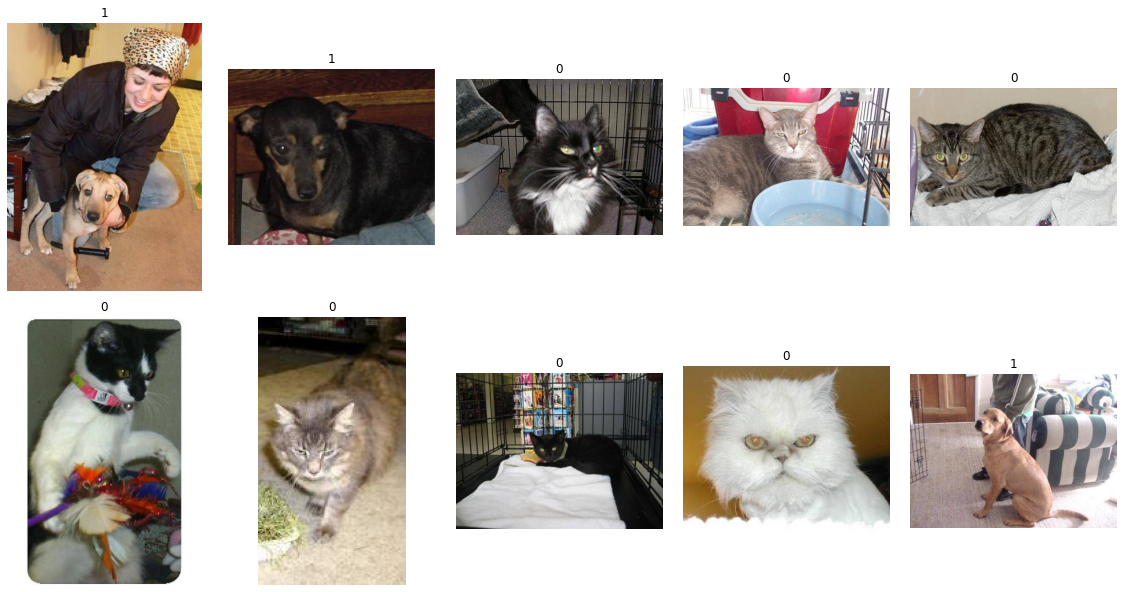

In [8]:
plot_images(X_train_small, y_train_small, 10)

#### Pickle Files

Next, I will continue with pickle (and unpickle) the files in order to run the code on Kaggle, using a GPU.  

In [ ]:
#os.mkdir("pickled_files")

In [ ]:
def pickle_file(dataset:object, filename:str) -> None: #Reference: https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object
    """
    Pickles a file.
    
    Parameters
    ----------
    dataset : object
        The dataset to pickle
    filename : str
        The name to save the file as
    
    Returns
    -------
    None
    """
    
    with open(f"pickled_files/{filename}.pickle", "wb") as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#pickle_file(X_train_small, "X_train_small")
#pickle_file(X_val_small, "X_val_small")
#pickle_file(X_test_small, "X_test_small")
#pickle_file(X_train_tiny, "X_train_tiny")
#pickle_file(X_val_tiny, "X_val_tiny")
#pickle_file(X_test_tiny, "X_test_tiny")

#pickle_file(y_train_small, "y_train_small")
#pickle_file(y_val_small, "y_val_small")
#pickle_file(y_test_small, "y_test_small")
#pickle_file(y_train_tiny, "y_train_tiny")
#pickle_file(y_val_tiny, "y_val_tiny")
#pickle_file(y_test_tiny, "y_test_tiny")

In [3]:
def open_pickled_file(filename:str) -> object:
    """
    Opens a pickled file.
    
    Parameters
    ----------
    filename : str
        The name of the dataset to open
    
    Returns
    -------
    file : object
        The unpickled file
    """
    
    with open(f'../input/dogsvscats/{filename}.pickle', 'rb') as handle:
        file = pickle.load(handle)
        return file

In [4]:
X_train_small = open_pickled_file("X_train_small")
X_val_small = open_pickled_file("X_val_small")
X_test_small = open_pickled_file("X_test_small")
X_train_tiny = open_pickled_file("X_train_tiny")
X_val_tiny = open_pickled_file("X_val_tiny")
X_test_tiny = open_pickled_file("X_test_tiny")

y_train_small = open_pickled_file("y_train_small")
y_val_small = open_pickled_file("y_val_small")
y_test_small = open_pickled_file("y_test_small")
y_train_tiny = open_pickled_file("y_train_tiny")
y_val_tiny = open_pickled_file("y_val_tiny")
y_test_tiny = open_pickled_file("y_test_tiny")

In [10]:
# Number of samples in each dataset
print(X_train_small.shape, X_val_small.shape, X_test_small.shape, X_train_tiny.shape, X_val_tiny.shape, X_test_tiny.shape)
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

# Example of one sample
print(X_train_small[0].shape)

(1600,) (400,) (500,) (160,) (40,) (50,)
(1600,) (400,) (500,) (160,) (40,) (50,)
(499, 362, 3)


#### Skapa lämplig plot för att kontrollera att dataseten är balanserade

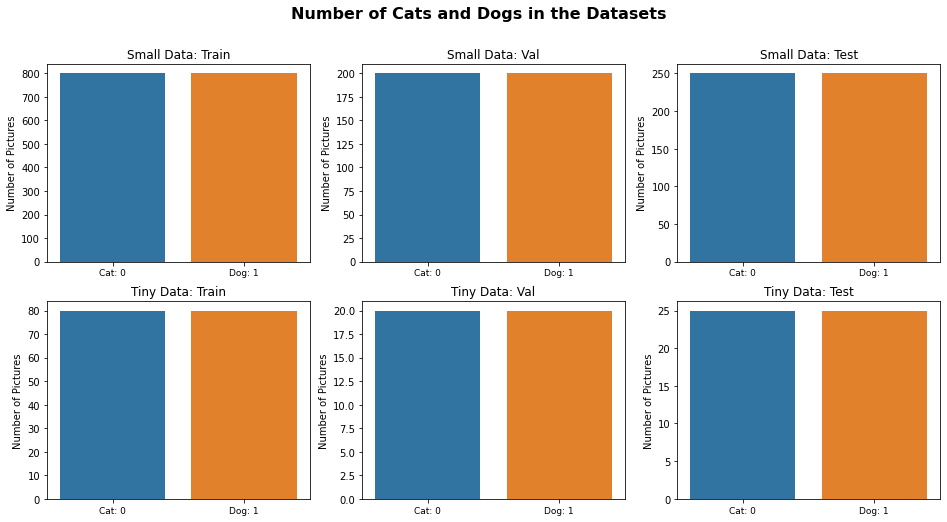

In [8]:
datasets = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_names = ["Small Data: Train", "Small Data: Val", "Small Data: Test", "Tiny Data: Train", "Tiny Data: Val", "Tiny Data: Test"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), datasets, dataset_names):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of Pictures")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=9)

fig.suptitle("Number of Cats and Dogs in the Datasets", size=16, fontweight="bold");

#### Skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

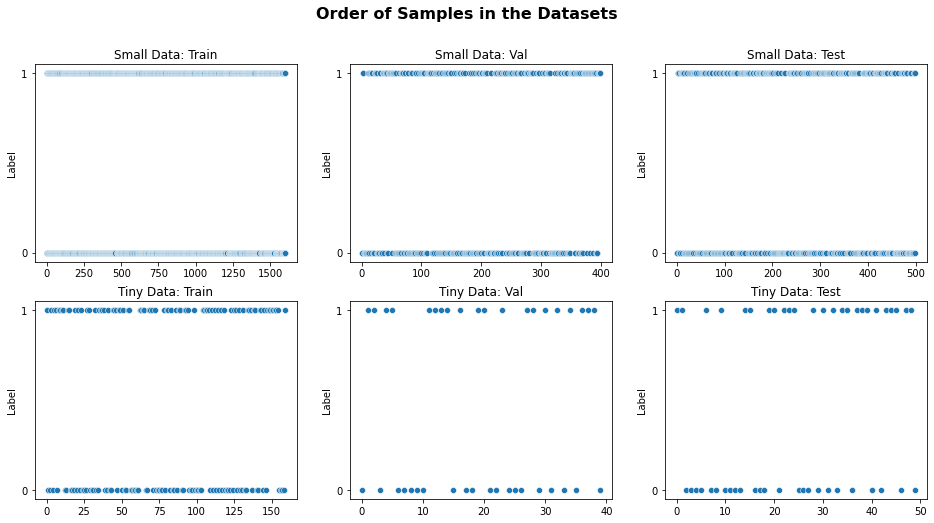

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), datasets, dataset_names):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Label")
    ax.locator_params(axis='y', nbins=2)
    ax.set_yticks([0, 1])

fig.suptitle("Order of Samples in the Datasets", size=16, fontweight="bold");

## 1. Bildbehandling (*)

Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

### a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [10]:
# Saves height and width (number of pixels) for small and tiny data
height_small = [X_train_small[i].shape[0] for i in range(len(X_train_small))]
width_small = [X_train_small[i].shape[1] for i in range(len(X_train_small))]

height_tiny = [X_train_tiny[i].shape[0] for i in range(len(X_train_tiny))]
width_tiny = [X_train_tiny[i].shape[1] for i in range(len(X_train_tiny))]

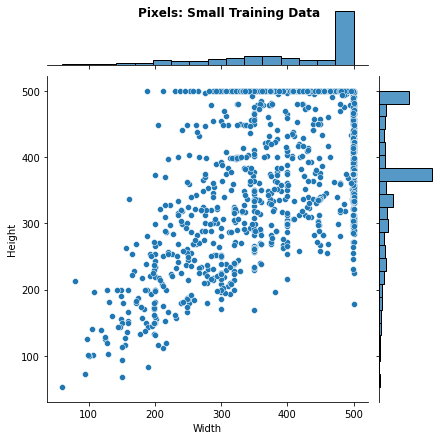

In [11]:
fig = sns.jointplot(x=width_small, y=height_small)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Small Training Data", size=12, fontweight="bold");

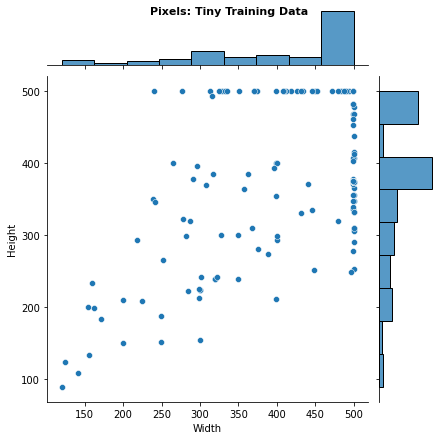

In [12]:
fig = sns.jointplot(x=width_tiny, y=height_tiny)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Tiny Training Data", size=11, fontweight="bold");

### b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

In [ ]:
count = 0

for height, width in zip(height_small, width_small):
    if height < 150 or width < 150: 
        count += 1
        
print(f"{count} out of a {len(height_small)} images had a width or a height smaller than 150.")

In the plots above we can see that the smallest image in the small training data has a size of about 50 x 50 and that the largest image has a size of about 500 x 500. It is also common with images where one side has a size of 500 and the other side is approximately between 200-500.

Even though I have access to a GPU, I believe that running the models will take quite a lot of time, and I therefore do not want to use too large a file size. The CNN that I will create below has four kernels with 32, 64, 128 and 128 filters respectively and 512 nodes in the Dense MLP layer. With an image size of 150 x 150 the network will have 3,453,121 trainable parameters and with an image size of 200 x 200 this will become 6,795,457, i.e. almost the double. The training time will also increase accordingly. 

However, I believe that accurately classifying dogs and cats is a much more complex problem than for example classifying numbers. For the classic MNIST data a file size of 28 x 28 has been shown to be enough to gain over 99% accuracy (reference). In this data, the numbers are nicely centered in the image and consists of a few simple elements, such as lines and circles. A dog and a cat are much more similar than a 1 and a 0. They both have eyes, nose and a tail, even though they look somewhat different. Dogs and cats also differs a lot within there group, which makes it even more difficult for the model to learn. Furthermore, the cats and dogs in this dataset are not centered in the images. Therefore, I believe that we should use a larger size for this data, to be able to capture all of this information. Chollet (2017) used a size of 150 x 150, which worked reasonably well. I therefore based my decision on this earlier attemt to classify the data and I could later conclude that the models ran quite fast. 

Changing the size to 150 x 150 means that the majority of images will be downscaled and that only 43 (in the training data) will be upscaled. I decide to continue with all of the images, since there are only a few images that will be upscaled, and I do not want to throw away information (since I only have 1600 training images).

Later, I will also try to run the model with image sizes of 100 x 100 and 200 x 200, to investigate if the model will perform better. 

### c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande struktur:

(samples, row, cols, color_channels)

In [5]:
def resize_images(data:np.ndarray, size:tuple) -> np.ndarray:
    """
    Resizes images.
    
    Parameters
    ----------
    data : np.ndarray
        The images to resize
    size : tuple
        The size of the images as a tuple (height, width)
    
    Returns
    ------
    data_resized : np.ndarray
        The resized images
    """
    
    data_resized = [cv2.resize(data[i], size) for i in range(len(data))]
    data_resized = np.array(data_resized)
    
    return data_resized

In [6]:
X_train_small_150 = resize_images(X_train_small, (150, 150))
X_val_small_150 = resize_images(X_val_small, (150, 150))
X_test_small_150 = resize_images(X_test_small, (150, 150))
X_train_tiny_150 = resize_images(X_train_tiny, (150, 150))
X_val_tiny_150 = resize_images(X_val_tiny, (150, 150))
X_test_tiny_150 = resize_images(X_test_tiny, (150, 150))

print(X_train_small_150.shape, X_val_small_150.shape, X_test_small_150.shape) 
print(X_train_tiny_150.shape, X_val_tiny_150.shape, X_test_tiny_150.shape)

(1600, 150, 150, 3) (400, 150, 150, 3) (500, 150, 150, 3)
(160, 150, 150, 3) (40, 150, 150, 3) (50, 150, 150, 3)


#### Visualisera därefter ett par styckena bilder.

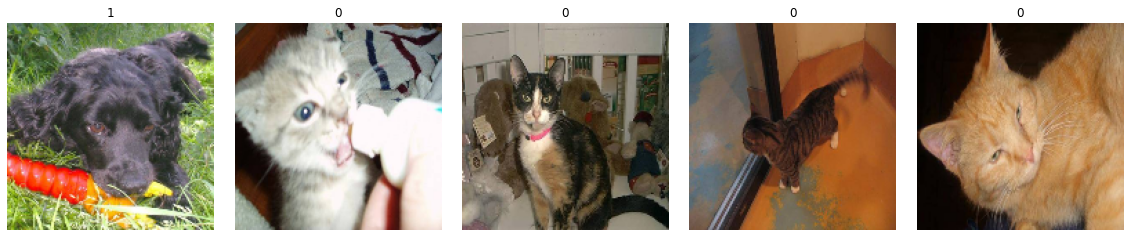

In [33]:
plot_images(X_train_small_150, y_train_small, 5, random_sample=True)

### d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?

Data augmentation is used to make the model generalise better to the test data and to reduce overfitting. For each training batch the ImageDataGenerator creates a random set of augmented training data, where each picture is changed (for example zoomed in or rotated). The original data is in this way replaced by the augmented data. (reference)   

I based my decision on what Chollet (2017) had earlier done. Width_shift_range and height_shift_range randomly shifts the images in the vertical or horizontal direction. Shear turns the image along an axis in order to get a different perception angle (reference), whereas zoom randomly zooms into the picture. Setting horizontal_flip to True makes sense in this case, since we work with animals who can be seen from different angles (this would not make sense if we instead worked with for example numbers).

Chollet had chosen a rotation range (how much the image is rotated) of 0.4, which I thought seemed a bit too high. I will therefore initialise it to 0.3 and I will later compare the rotation ranges to see which model performs best.

https://stackoverflow.com/questions/57301330/what-exactly-the-shear-do-in-imagedatagenerator-of-keras


In [7]:
#Scales the data
scaled_X_train_small_150 = X_train_small_150.astype("float32") / 255
scaled_X_val_small_150 = X_val_small_150.astype("float32") / 255
scaled_X_test_small_150 = X_test_small_150.astype("float32") / 255
print(f"scaled_X_train_small: Min: {scaled_X_train_small_150.min()}, Max: {scaled_X_train_small_150.max()}")

scaled_X_train_small: Min: 0.0, Max: 1.0


In [8]:
def create_generator(X_train:np.ndarray, y_train:np.ndarray, X_val:np.ndarray, y_val:np.ndarray, rotation:int) -> NumpyArrayIterator:
    """
    Initialises ImageDataGenerators for training and validation data. 
    
    Parameters
    ----------
    X_train : np.ndarray
        The training data images
    y_train : np.ndarray
        The training data labels
    X_val : np.ndarray
        The validation data images 
    y_val : np.ndarray
        The validation data labels
    rotation : int
        The rotation angle
        
    Returns
    -------
    train_generator, val_generator : tuple[NumpyArrayIterator, NumpyArrayIterator]
        The training data generator and the validation data generator
    """
    
    train_image_generator = ImageDataGenerator(
                            rotation_range=rotation,
                            shear_range=.2,
                            zoom_range=.2,
                            horizontal_flip=True, 
                            height_shift_range=.2, 
                            width_shift_range=.2)

    val_image_generator = ImageDataGenerator()

    train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
    val_generator = val_image_generator.flow(X_val, y_val, batch_size=32)
    
    return train_generator, val_generator

In [9]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

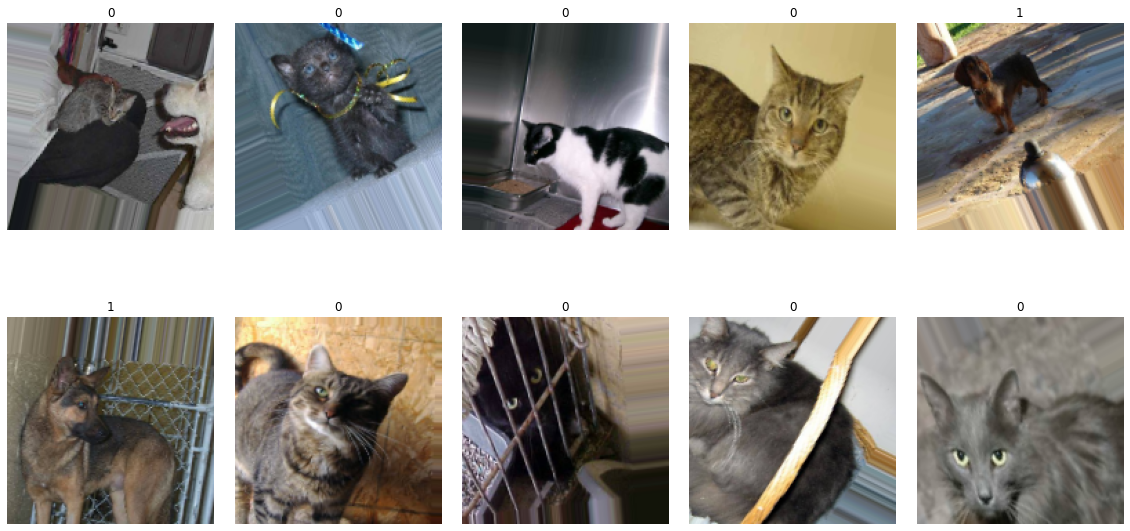

In [37]:
# Plots examples of the augmented images
sample_batch = train_generator_small.next() 
plot_images(sample_batch[0], sample_batch[1], 10)

## 2. Träna modeller (*)
### För uppgifterna nedan, jobba med dataseten en åt gången:

small:
- utan augmentering
- med augmentering

tiny (BONUS):
- utan augmentering
- med augmentering

In [16]:
def CNN_model(input_shape:tuple, kernels:list, optimizer:keras.optimizers, learning_rate:float, dropout_rate:float) -> Sequential:
    """
    Creates a CNN model. 
    
    Parameters
    ----------
    input_shape : tuple[int, int, int]
        The shape of one image
    kernels : list
        The sizes of the kernels from first to last layer
    optimizer : keras.optimizers
        Name of the optimizer to use when compiling
    learning_rate : float
        The learning rate for the specified optimizer
    dropout_rate : float
        The dropout rate
        
    Returns
    -------
    model : Sequential
        The CNN model
    """
    
    model = Sequential(name="CNN_model")

    # The convolutional layers
    for kernel in kernels:
        conv_layer = Conv2D(kernel, 
                            kernel_size=(3, 3), 
                            activation="relu", 
                            kernel_initializer="he_normal", 
                            input_shape=input_shape)
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer=optimizer(learning_rate=learning_rate), metrics=["acc"])

    return model

model = CNN_model(input_shape=(150, 150, 3), kernels=[32, 64, 128, 128], optimizer=Adam, learning_rate=.001, dropout_rate=.3)
model.summary()   

2022-05-12 17:05:10.698447: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       14

In [17]:
def create_CNN_model(train_data:list, val_data:list, input_shape:tuple, kernels:list=[32, 64, 128, 128], 
                     optimizer:keras.optimizers=Adam, learning_rate:float=.001, 
                     dropout_rate:float=.3, early_stop_patience:int=25) -> Sequential:
    """
    Creates a CNN model. 
    
    Parameters
    ----------
    train_data : list
        The X and y training data as [X, y] OR a generator object
    val_data : list
        The X and y validation as [X, y] data OR a generator object
    input_shape : tuple[int, int, int]
        The shape of one image
    kernels : list
        The number of filters in the kernels, from first to last (default [32, 64, 128, 128])
    optimizer : keras.optimizers
        Name of the optimizer to use when compiling (default Adam)
    learning_rate : float
        The learning rate for the specified optimizer (default .001)
    dropout_rate : float
        The dropout rate (default .3)
    early_stop_patience : int
        The number of epochs without improvement before training will stop
        
    Returns
    -------
    model : Sequential
        The fitted CNN model
    """

    early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = early_stop_patience, restore_best_weights = True)
    
    model = CNN_model(input_shape=input_shape, kernels=kernels, optimizer=optimizer, learning_rate=learning_rate, dropout_rate=dropout_rate)
    
    if len(train_data) == 2:        
        model.fit(train_data[0], train_data[1], 
                  epochs = 200, 
                  callbacks = [early_stopper], 
                  validation_data=(val_data[0], val_data[1]))          
    else:    
        model.fit(train_data[0], 
                 steps_per_epoch = 50, 
                 epochs = 200,
                 callbacks = [early_stopper], 
                 validation_data = val_data[0], 
                 validation_steps = 12)
    
    return model

In [10]:
def plot_metrics(model, title):
    """
    Plots loss and accuracy history for a trained model. 
    
    Parameters
    ----------
    model : Sequential
        The trained model
    title : str
        The title of the plot with info about hyperparameters

    Returns
    -------
    None
    """
    
    metrics = pd.DataFrame(model.history.history)
    
    fig, ax = plt.subplots(1, 2, figsize = (12,4))
    
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    ax[0].legend(["Training Loss", "Validation Loss"])
    
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)
    ax[1].legend(["Training Accuracy", "Validation Accuracy"])
    
    fig.suptitle(title)

## Without Augmentation

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

#### Hyperparameter tuning

I will test two different optimizers, Adam and RMSprop, in combination with different learning rates (.0005, 001, 005). 

I will also try out two different patience values (15 and 25) for early stopping. I will use early stopping throughout this lab. Since some of the models train for a long time, it is convenient that the model stops by itself when accuracy is no longer improving. 

In [21]:
model = create_CNN_model([scaled_X_train_small_150, y_train_small], [scaled_X_val_small_150, y_val_small], input_shape=(150, 150, 3), optimizer=Adam, learning_rate=.005, early_stop_patience=25)

Epoch 1/200
50/50 [==============================] - 28s 546ms/step - loss: 1.5285 - acc: 0.5100 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/200
50/50 [==============================] - 27s 532ms/step - loss: 0.6915 - acc: 0.5206 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 3/200
50/50 [==============================] - 27s 542ms/step - loss: 0.6914 - acc: 0.5719 - val_loss: 0.6953 - val_acc: 0.5000
Epoch 4/200
50/50 [==============================] - 27s 545ms/step - loss: 0.6944 - acc: 0.5000 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 5/200
50/50 [==============================] - 27s 539ms/step - loss: 0.6875 - acc: 0.5269 - val_loss: 0.6893 - val_acc: 0.5225
Epoch 6/200
50/50 [==============================] - 27s 541ms/step - loss: 0.6990 - acc: 0.5113 - val_loss: 0.6896 - val_acc: 0.5050
Epoch 7/200
50/50 [==============================] - 27s 541ms/step - loss: 0.6865 - acc: 0.5481 - val_loss: 0.6901 - val_acc: 0.5250
Epoch 8/200
50/50 [==============================] - 26s 526ms

0.5724999904632568


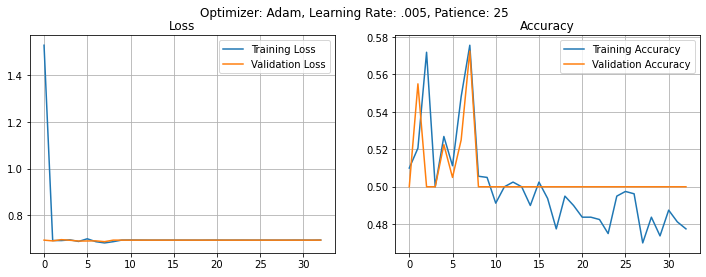

In [22]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam, Learning Rate: .005, Patience: 25")

#### Summary of Results Without Augmentation (Table 1)

|Optimizer|Learning Rate|Patience|Number of Epochs|Best Validation Accuracy              |
|---------|-------------|--------|----------------|--------------------------------------|
| Adam    | .0005       | 15     | 8/23           | .717                                 |
| Adam    | .0005       | 25     | 39/64          | <span style="color:blue"><b>.730</span>  |
| Adam    | .001        | 15     | 13/28          | .688                                 |
| Adam    | .001        | 25     | 14/39          | .690                                 |
| Adam    | .005        | 15     | 1/16           | .505                                 |
| Adam    | .005        | 25     | 8/33           | .573                                 |
| RMSprop | .0005       | 15     | 23/38          | .705                                 |
| RMSprop | .0005       | 25     | 53/78          | <span style="color:blue"><b>.755</span>  |
| RMSprop | .001        | 15     | 10/25          | .690                                 |
| RMSprop | .001        | 25     | 22/47          | .728                                 |
| RMSprop | .005        | 15     | 14/29          | .720                                 |
| RMSprop | .005        | 25     | 27/52          | .715                                 |

Both RMSprop and Adam performed best with a learning rate of .0005 and with a patience of 25 for early stopping. 

### b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför.

Glöm inte att evaluera på valideringsdatan.

#### Change Number of Filters in Last Kernel and Increase Dropout Rate

I continue with changing the last kernel from 128 to 256, so that the kernels are [32, 64, 128, 256]. It is common to increase the number of filters for each layer in CNN, since the early layers learns "easy" patterns, such as edges, and the later layers learns more complex patterns and combines the information from earlier layers. To be able to represent as many combinations of patterns as possible, it is often prefered that the number of filters increases gradually. (reference, stackoverflow)

In this section, I also try out different dropout rates, since all of the earlier models overfitted.

In [ ]:
model = create_CNN_model([scaled_X_train_small_150, y_train_small], 
                         [scaled_X_val_small_150, y_val_small], 
                         input_shape=(150, 150, 3), 
                         kernels=[32, 64, 128, 128], 
                         optimizer=Adam, learning_rate=.0005, 
                         early_stop_patience=25, 
                         dropout_rate=.7)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam(.0005), Patience: 25, Layers:[32, 64, 128, 128], Drop Rate: .7")

#### Summary of Results Without Augmentation (Table 2)

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|-----------|
|32, 64, 128, 128| Adam   | .0005  | 25     | .3 | 39/64   | .730**    |
|32, 64, 128, 128| Adam   | .0005  | 25     | .6 | 20/45   | .728      |
|32, 64, 128, 128| Adam   | .0005  | 25     | .7 | 34/59   | <span style="color:blue"><b>.785</span>      |
|32, 64, 128, 128| Adam   | .0005  | 25     | .8 | 69/94   | .780      |
|32, 64, 128, 128| Adam   | .001   | 25     | .4 | 20/45   | .707      |
|32, 64, 128, 128| Adam   | .001   | 25     | .5 | 44/69   | .740      |
|32, 64, 128, 128| Adam   | .001   | 25     | .6 | 39/64   | .745      |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | 35/60   | <span style="color:blue"><b>.770</span>      |
|32, 64, 128, 128| Adam   | .001   | 25     | .8 | 50/75   | .750      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | 53/78   | .755*     |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .4 | 35/60   | .730      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .5 | 17/42   | .712      |
|32, 64, 128, 256| Adam   | .0005  | 25     | .3 | 44/69   | .738      |
|32, 64, 128, 256| Adam   | .0005  | 25     | .5 | 23/48   | .735      |
|32, 64, 128, 256| Adam   | .001   | 25     | .3 | 12/37   | .720      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 20/45   | .725      |
|32, 64, 128, 256| Adam   | .001   | 25     | .5 | 51/76   | .740      |
|32, 64, 128, 256| Adam   | .001   | 25     | .6 | 20/45   | .733      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .3 | 32/57   | .712      | 
|32, 64, 128, 256| RMSprop| .0005  | 25     | .4 | 51/76   | .745      | 
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | 70/95   | <span style="color:blue"><b>.767</span>      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .6 | 39/64   | .740      |

\* Best score from last run <br>
** Second best score from last run <br>

In general, increasing the dropout rate a bit made the models perform better. Increasing the number of filters in the last kernel did not seem to have any significant effect for these combinations of hyperparameters. Interestingly, the two best models had different number of filters in the last kernel. 

In the next section, I will try the different kernels in combination with different images sizes, and continue adjusting the dropout rate. 

#### Change Image Size

I also want to test if the model improves with smaller and larger image sizes. I test (100, 100) and (200, 200). 

In [20]:
X_train_small_100 = resize_images(X_train_small, (100, 100))
X_val_small_100 = resize_images(X_val_small, (100, 100))
X_train_small_200 = resize_images(X_train_small, (200, 200))
X_val_small_200 = resize_images(X_val_small, (200, 200))

scaled_X_train_small_200 = X_train_small_200.astype("float32") / 255
scaled_X_val_small_200 = X_val_small_200.astype("float32") / 255
scaled_X_train_small_100 = X_train_small_100.astype("float32") / 255
scaled_X_val_small_100 = X_val_small_100.astype("float32") / 255

In [ ]:
model = create_CNN_model([scaled_X_train_small_150, y_train_small], 
                         [scaled_X_val_small_150, y_val_small], 
                         input_shape=(150, 150, 3), 
                         kernels=[32, 64, 128, 256], 
                         optimizer=Adam, learning_rate=.0005, 
                         early_stop_patience=25, 
                         dropout_rate=0.7)

0.7524999976158142


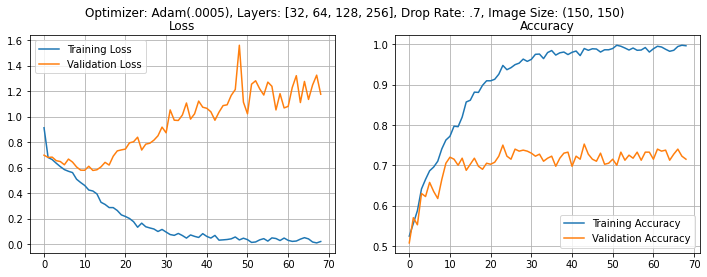

In [46]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam(.0005), Layers: [32, 64, 128, 256], Drop Rate: .9, Image Size: (150, 150)")

#### Summary of Results Without Augmentation (Table 3)

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Image Size|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|------------|---------|-------|
|32, 64, 128, 128| Adam   | .0005  | 25     | .7 | (100, 100) | 67/92   | .803  |
|32, 64, 128, 128| Adam   | .0005  | 25     | .7 | (150, 150) | 34/59   | .785* |
|32, 64, 128, 128| Adam   | .0005  | 25     | .7 | (200, 200) | 16/41   | .738  |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (100, 100) | 73/98   | .798  |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (150, 150) | 35/60   | .770** |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (200, 200) | 38/63   | .738  |
|32, 64, 128, 128| Adam   | .001   | 25     | .9 | (200, 200) | 73/98   | .762  |
|32, 64, 128, 128| Adam   | .001   | 25     | .95| (200, 200) | 13/38   | .575  |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (100, 100) | 21/46   | .730  |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (150, 150) | 53/78   | .755†|
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (200, 200) | 9/34    | .705  |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .7 | (200, 200) | 16/41   | .748  |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .9 | (200, 200) | 94/119  | .830  |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .95| (200, 200) | 85/110  | .798  |
|32, 64, 128, 256| Adam   | .0005  | 25     | .7 | (100, 100) | 49/74   | .777  |
|32, 64, 128, 256| Adam   | .0005  | 25     | .7 | (150, 150) | 44/69   | .753  |
|32, 64, 128, 256| Adam   | .0005  | 25     | .7 | (200, 200) | 27/52   | .728  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (100, 100) | 47/72   | .755  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (150, 150) | 70/95   | .767*** |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (200, 200) | 27/52   | .707  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .6 | (200, 200) | 61/86   | .735  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .7 | (200, 200) | 44/69   | .755  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .8 | (200, 200) | 51/76   | .770  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .9 | (200, 200) | 46/71   | <span style="color:blue"><b>.800</span>      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .95| (200, 200) | 94/119  | .825  |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .96| (200, 200) | 131/156 | <span style="color:blue"><b>.832</span>      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .97| (200, 200) | 87/112  | .793  |

\* Best score from previous models <br>
\** Second best score from previous models <br>
\*** Third best score from previous models <br>
† Best score from previous model, using RMSprop and 256 filterns in last kernel

Adam performed better with smaller sizes, where 100 x 100 performed better than 150 x 150 and 150 x 150 performed better than 200 x 200, for all the different combinations. Such a pattern did not exist for RMSprop.  

I gradually increased the dropout rate and was a bit surprised to see that the validation accuracy increased up until a dropout rate of .97. The model reached its highest accuacy (.832) with a dropout rate of .96, meaning that the network has randomly dropped 96% of the variables from the previous stages (reference). Later I found that (ref) had used a droput rate of .9 with good results as well. 

The model performed best (accuracy=.832) with a very high dropout rate (.96). However, based on the plots, the model performed more evenly with a dropout rate of .9 (accuracy=.800) and I will therefore continue with that model and predict on the test data. 

### c) Välj en modell, träna på tränings- och valideringsdatan. Gör inferens på testdatan och utvärdera din modell.

In [83]:
# Resize test images to 200
X_test_small_200 = resize_images(X_test_small, (200, 200))
scaled_X_test_small_200 = X_test_small_200.astype("float32") / 255

In [84]:
# Concatenate training and validation data
X_train_full = np.concatenate((scaled_X_train_small_200, scaled_X_val_small_200))
y_train_full = np.concatenate((y_train_small, y_val_small))
X_train_full.shape, y_train_full.shape

((2000, 200, 200, 3), (2000,))

In [ ]:
final_model_no_aug = CNN_model(input_shape=(200, 200, 3), kernels=[32, 64, 128, 256], optimizer=RMSprop, learning_rate=.0005, dropout_rate=.9)
final_model_no_aug.fit(X_train_full, y_train_full, epochs=46)

In [ ]:
y_pred_small_no_aug = final_model_no_aug.predict(scaled_X_test_small_200)
y_pred_small_no_aug = (y_pred_small_no_aug > .5)*1

In [71]:
def print_and_plot_results(y_true:np.ndarray, y_pred:np.ndarray, data_name:str) -> None:
    """
    Prints a classification report and plots a confusion matrix. 
    
    Parameters
    ----------
    y_true : np.ndarray
        The true y-values
    y_pred : np.ndarray
        The predicted y-values
    data_name : str
        The name of the model
    """

    classification_report_ = classification_report(y_true, y_pred)
    print(f"Classification Report for {data_name}: \n {classification_report_}")
    
    cm = confusion_matrix(y_true, y_pred)
    cm_fig = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"]).plot()
    _ = cm_fig.ax_.set(title=f"{data_name}: Results on Test Data")


In [ ]:
print_and_plot_results(y_test_small, y_pred_small_no_aug, "Data Without Augmentation")

I was very surprised of how well the model performed and I therefore decided to generate some more test data in order to see if this was just a coincidence. 

In [69]:
with open(f'../input/dogsvscats-additional-data/X_test_small2.pickle', 'rb') as handle:
    X_test_small2 = pickle.load(handle)

with open(f'../input/dogsvscats-additional-data/y_test_small2.pickle', 'rb') as handle:
    y_test_small2 = pickle.load(handle)    

In [70]:
# Resize test2 images to 200
X_test_small_200_2 = resize_images(X_test_small2, (200, 200))
scaled_X_test_small_200_2 = X_test_small_200_2.astype("float32") / 255

In [ ]:
y_pred_small_no_aug2 = final_model_no_aug.predict(scaled_X_test_small_200_2)
y_pred_small_no_aug2 = (y_pred_small_no_aug2 > .5)*1

In [ ]:
print_and_plot_results(y_test_small2, y_pred_small_no_aug2, "Data Without Augmentation")

From this we can see that the model performed slightly worse on the new test data, but that the results are still pretty good. I double checked my code for data leakage, but could not find any. The test sets contain 500 images each so I believe that a difference in accuracy by 5% could be explained by coincidence. It could be that one of the test set contains slightly more difficult pictures. 

In [ ]:
final_model_no_aug.save("DogsVsCatsPredictorWithoutAug.h5")

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('./DogsVsCatsPredictorNoAug.h5')

### d) Tag ett eller flera av nätverken (VGG16, Resnet, Xception, Inception), läs deras forskningsartikel, sammanfatta kort ca 1/2 - 1 sida för en artikel. Utför därefter transfer learning och evaluera din modell. Beskriv också hur transfer learning fungerar.

The code is loosely based on ...

In [12]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [85]:
def VGG16_model(input_shape:tuple, number_nodes:int=512, optimizer:keras.optimizers=RMSprop,
                learning_rate:float=.00002, dropout_rate:float=.3, 
                fast_feature_extraction:bool=False, fine_tuning:bool=False):
    """
    Parameters
    ----------
    input_shape : tuple[int, int, int]
        The shape of one image    
    number_nodes : int
        Number of nodes in the dense MLP layer (default 256)
    optimizer : keras.optimizers
        Name of the optimizer to use when compiling (default RMSprop)    
    learning_rate : float
        Learning rate for the optimizer (default .00002)
    dropout_rate : float
        The dropout rate (default .3)
    fast_feature_extraction : bool
        True: Should be True when fitting extracted features (values already predicted by the VGG16 model) 
        False (default): When fitting the X and y (non pretrained) data
    fine_tuning : bool
        True: Unfreezing block5_conv1, block5_conv2, block5_conv3 and block5_pool in the base model
        False (default): All layers in the base model are freezed
        
    Returns
    -------
    model : Sequential
        The VGG16 model
    """
    
    # Creates MLP model
    model = Sequential()
    if fast_feature_extraction == False:
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
        model.add(base_model)
    model.add(Flatten())
    model.add(Dense(number_nodes, activation="relu", kernel_initializer="he_normal"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    # Freezes all layers, except for the last block if fine tuning is True. Reference: Chollet (2017)
    if fast_feature_extraction == False:
        set_trainable = False    
        for layer in base_model.layers:
            if layer.name == "block5_conv1" and fine_tuning == True:
                set_trainable = True # When set to True, sets all of the additional layers to trainable
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
       
    model.compile(optimizer=RMSprop(learning_rate), loss="binary_crossentropy", metrics=["acc"])   
    
    return model

In [40]:
train_features = base_model.predict(scaled_X_train_small_200, batch_size=32)
val_features = base_model.predict(scaled_X_val_small_200, batch_size=32)

2022-05-12 20:17:53.316234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768000000 exceeds 10% of free system memory.
2022-05-12 20:17:54.066417: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768000000 exceeds 10% of free system memory.


In [ ]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 25, restore_best_weights = True)

model = VGG16_model(input_shape=(200, 200, 3), number_nodes=256, optimizer=RMSprop,
                    learning_rate=.000002, dropout_rate=.5, fast_feature_extraction=True)

model.fit(train_features, y_train_small,
          epochs=200,
          callbacks=[early_stopper],
          batch_size=32,
          validation_data=(val_features, y_val_small))

0.8999999761581421


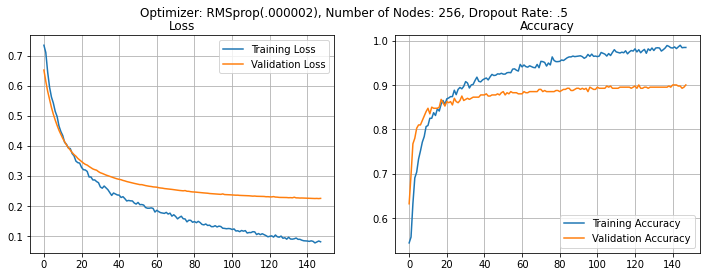

In [67]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: RMSprop(.000002), Number of Nodes: 256, Dropout Rate: .5")

|Number of Nodes|Optimizer|Learning Rate|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|---------------|---------|-------------|------------|----------------|------------|
| 256           |Adam     | .00002      | .5         | 35/60          | .925       |
| 256           |Adam     | .00002      | .6         | 30/55          | .923       |
| 256           |Adam     | .0002       | .5         | 33/58          | .925       |
| 256           |RMSprop  | .000002     | .5         | 123/148        | .900       |
| 256           |RMSprop  | .00002      | .4         | 18/43          | .918       |
| 256           |RMSprop  | .00002      | .5         | 36/61          | .925       |
| 256           |RMSprop  | .00002      | .6         | 26/51          | .923       |
| 256           |RMSprop  | .0002       | .5         | 10/35          | .920       |
| 512           |RMSprop  | .00002      | .5         | 3/28           | .918       |
| 512           |Adam     | .00002      | .5         | 17/42          | .915       |



In [88]:
train_features_full = base_model.predict(X_train_full, batch_size=32)

final_transfer_model_no_aug_small = VGG16_model(input_shape=(200, 200, 3), number_nodes=256, 
                                                optimizer=RMSprop, learning_rate=.00002, 
                                                dropout_rate=.5, fast_feature_extraction=True)

final_transfer_model_no_aug_small.fit(train_features_full, y_train_full, epochs=36, batch_size=32)

Epoch 1/36
63/63 [==============================] - 1s 5ms/step - loss: 0.5507 - acc: 0.7105
Epoch 2/36
63/63 [==============================] - 0s 4ms/step - loss: 0.3753 - acc: 0.8350
Epoch 3/36
63/63 [==============================] - 0s 4ms/step - loss: 0.3177 - acc: 0.8655
Epoch 4/36
63/63 [==============================] - 0s 4ms/step - loss: 0.2717 - acc: 0.8930
Epoch 5/36
63/63 [==============================] - 0s 4ms/step - loss: 0.2374 - acc: 0.9000
Epoch 6/36
63/63 [==============================] - 0s 5ms/step - loss: 0.2154 - acc: 0.9100
Epoch 7/36
63/63 [==============================] - 0s 4ms/step - loss: 0.2000 - acc: 0.9180
Epoch 8/36
63/63 [==============================] - 0s 4ms/step - loss: 0.1789 - acc: 0.9310
Epoch 9/36
63/63 [==============================] - 0s 4ms/step - loss: 0.1658 - acc: 0.9415
Epoch 10/36
63/63 [==============================] - 0s 4ms/step - loss: 0.1561 - acc: 0.9470
Epoch 11/36
63/63 [==============================] - 0s 4ms/step - lo

In [90]:
test_features_full = base_model.predict(scaled_X_test_small_200, batch_size=32)

y_pred_transfer_no_aug = final_transfer_model_no_aug_small.predict(test_features_full)
y_pred_transfer_no_aug = (y_pred_transfer_no_aug > .5)*1

Classification Report for Transfer Learning with Fast Feature Extraction: Data Without Augmentation: 
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       250
           1       0.89      0.95      0.92       250

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



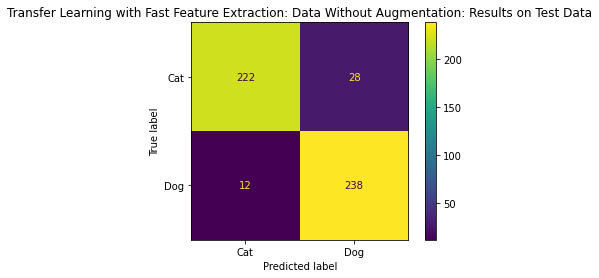

In [91]:
print_and_plot_results(y_test_small, y_pred_transfer_no_aug, "Transfer Learning with Fast Feature Extraction: Data Without Augmentation")

## With Augmentation

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

#### Hyperparameter tuning

In [ ]:
model = create_CNN_model([train_generator_small], 
                         [val_generator_small], 
                         input_shape=(150, 150, 3),
                         optimizer=Adam, 
                         learning_rate=.0005, 
                         early_stop_patience=15)

0.7942708134651184


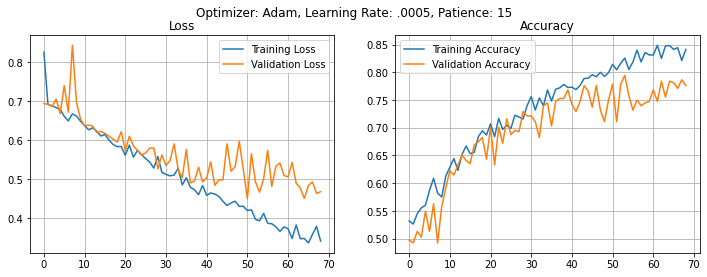

In [59]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam, Learning Rate: .0005, Patience: 15")

#### Summary of Results With Augmentation Table 4

|Optimizer|Learning Rate|Patience|Number of Epochs|Best Validation Accuracy|
|---------|-------------|--------|----------------|------------------------|
| Adam    | .0005       | 15     | 54/69          | .794                   |
| Adam    | .0005       | 25     | 91/116         | .841                   |
| Adam    | .001        | 15     | 76/91          | .792                   |
| Adam    | .001        | 25     | 110/135        | <span style="color:blue"><b>.857</span>|
| RMSprop | .0005       | 15     | 125/140        | .828                   |
| RMSprop | .0005       | 25     | 122/147        | .828                   |
| RMSprop | .001        | 15     | 86/101         | .826                   |
| RMSprop | .001        | 25     | 122/147        | <span style="color:blue"><b>.849</span>                   |
| RMSprop | .005        | 15     | 46/61          | .727                   |
| RMSprop | .005        | 25     | 58/83          | .737                   |

### b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför.

Glöm inte att evaluera på valideringsdatan.

#### Change Number of Filters in Last Kernel and Increase Dropout Rate

In [ ]:
model = create_CNN_model([train_generator_small], 
                         [val_generator_small], 
                         input_shape=(150, 150, 3),
                         kernels=[32, 64, 128, 256],
                         optimizer=Adam, 
                         learning_rate=.001, 
                         early_stop_patience=25, 
                         dropout_rate=.4)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam(.001), Patience: 25, Layers: [32, 64, 128, 256], Drop Rate: .4")

I continue with changing the last kernel to 256, so that the kernels are [32, 64, 128, 256]. I test this in combination with different dropout rates.

#### Summary of Results With Augmentation Table 5

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 110/135 | .857*     |
|32, 64, 128, 128| Adam   | .001   | 25     | .4 | 72/97   | .813      |
|32, 64, 128, 128| Adam   | .001   | 25     | .5 | 112/137 | .844      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 122/147 | .849**    |
|32, 64, 128, 128| RMSprop| .001   | 25     | .4 | 84/109  | .807      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .5 | 47/72   | .818      |
|32, 64, 128, 256| Adam   | .001   | 25     | .3 | 88/113  | .839      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 132/157 | <span style="color:blue"><b>.865</span>      |
|32, 64, 128, 256| Adam   | .001   | 25     | .5 | 88/113  | .805      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .3 | 163/188 | .841      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .4 | 97/122  | .820      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | 98/123  | .828      |

\* Best score from last run <br>
** Second best score from last run

The best performing model got .865. 

#### Change Rotation Range

In [28]:
train_generator_small_40, val_generator_small_40 = create_generator(scaled_X_train_small_150,
                                                                    y_train_small,
                                                                    scaled_X_val_small_150,
                                                                    y_val_small,
                                                                    rotation=40)

In [ ]:
model = create_CNN_model([train_generator_small_40], 
                         [val_generator_small_40], 
                         input_shape=(150, 150, 3),
                         kernels=[32, 64, 128, 128],
                         optimizer=RMSprop, 
                         learning_rate=.001,
                         early_stop_patience=25, 
                         dropout_rate=.3)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: RMSprop(.001), Layers:[32, 64, 128, 128], Drop Rate: .3, Rotation: 40")

#### Summary of Results With Augmentation Table 6

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Rotation|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 20      | 101/126 | .839      |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 30      | 110/135 | .857**    |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 40      | 145/170 | .852      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 20      | 42/67   | .784      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 30      | 122/147 | .849***   |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 40      | 187/200 | .846      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 20      | 42/67   | .792      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 30      | 132/157 | .865*     |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 40      | 72/97   | .844      |


\* Best from last run <br>
** Second best from earlier run <br>
*** Third best from earlier run <br>

Changing rotation to either 20 or 40 did not make the models perform better. 

#### Change Image Size

In [ ]:
X_train_small_100 = resize_images(X_train_small, (100, 100))
X_val_small_100 = resize_images(X_val_small, (100, 100))
X_train_small_200 = resize_images(X_train_small, (200, 200))
X_val_small_200 = resize_images(X_val_small, (200, 200))

scaled_X_train_small_200 = X_train_small_200.astype("float32") / 255
scaled_X_val_small_200 = X_val_small_200.astype("float32") / 255
scaled_X_train_small_100 = X_train_small_100.astype("float32") / 255
scaled_X_val_small_100 = X_val_small_100.astype("float32") / 255

In [ ]:
train_generator_small_100, val_generator_small_100 = create_generator(scaled_X_train_small_100,
                                                                      y_train_small,
                                                                      scaled_X_val_small_100,
                                                                      y_val_small,
                                                                      rotation=30)

train_generator_small_200, val_generator_small_200 = create_generator(scaled_X_train_small_200,
                                                                      y_train_small,
                                                                      scaled_X_val_small_200,
                                                                      y_val_small,
                                                                      rotation=30)

In [ ]:
model = create_CNN_model([train_generator_small_200], 
                         [val_generator_small_200], 
                         input_shape=(200, 200, 3),
                         kernels=[32, 64, 128, 256],
                         optimizer=Adam, 
                         learning_rate=.001,
                         early_stop_patience=25, 
                         dropout_rate=.7)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: Adam(.001), Layers:[32, 64, 128, 256], Drop Rate: .7, Image Size: (200, 200)")

#### Summary of Results With Augmentation Table 7

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Image Size|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 100, 100| 41/66   | .797      |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 150, 150| 110/135 | .857**    |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 200, 200| 122/147 | .849      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 100, 100| 103/128 | .831      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 150, 150| 122/147 | .849***   |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 200, 200| 128/153 | .859      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 100, 100| 107/132 | .823      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 150, 150| 132/157 | <span style="color:green"><b>.865</span>*     |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 200, 200| 112/137 | .862      |
|32, 64, 128, 256| Adam   | .001   | 25     | .7 | 200, 200| 129/154 | .844      |

\* Best from last run <br>
** Second best from earlier run <br>
*** Third best from earlier run <br>

### c) Välj en modell, träna på tränings- och valideringsdatan. Gör inferens på testdatan och utvärdera din modell.

In [ ]:
X_train_full_150 = np.concatenate((scaled_X_train_small_150, scaled_X_val_small_150))
y_train_full = np.concatenate((y_train_small, y_val_small))
X_train_full_150.shape, y_train_full.shape

In [ ]:
train_generator_full, _ = create_generator(X_train_full_150,
                                            y_train_full,
                                            X_test_small_150,
                                            y_test_small,
                                            rotation=30)

In [ ]:
final_model_aug = CNN_model(input_shape=(150, 150, 3), kernels=[32, 64, 128, 256], optimizer=Adam, learning_rate=.001, dropout_rate=.4)
final_model_aug.fit(train_generator_full, epochs=132)

In [ ]:
y_pred_small_aug = final_model_aug.predict(scaled_X_test_small_150)
y_pred_small_aug = (y_pred_small_aug > .5)*1

print_and_plot_results(y_test_small, y_pred_small_aug, "Data With Augmentation")

In [ ]:
final_model_aug.save("DogsVsCatsPredictor.h5")

### d) Tag ett eller flera av nätverken (VGG16, Resnet, Xception, Inception), läs deras forskningsartikel, sammanfatta kort ca 1/2 - 1 sida för en artikel. Utför därefter transfer learning och evaluera din modell. Beskriv också hur transfer learning fungerar.

In [ ]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

In [52]:
def VGG16_model(input_shape:tuple, number_nodes:int=256, learning_rate:float=.00002, dropout_rate:float=.3, fine_tuning:bool=False):
    """
    Parameters
    ----------
    input_shape : tuple[int, int, int
        The shape of one image    
    number_nodes : int
        Number of nodes in the dense MLP layer (default 256)
    learning_rate : float
        Learning rate for the optimizer (default .00002)
    dropout_rate : float
        The dropout rate (default .3)
    fine_tuning : bool
        True: Unfreezing block5_conv1, block5_conv2, block5_conv3 and block5_pool in the base model
        False (default): All layers in the base model are freezed
        
    Returns
    -------
    model : Sequential
        The VGG16 model
    """
    
    # Creates base model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Creates MLP model
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(number_nodes, activation="relu", kernel_initializer="he_normal"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    # Freezes all layers, except for the last block if fine tuning is True. Reference: Chollet (2017)
    set_trainable = False    
    for layer in base_model.layers:
        if layer.name == "block5_conv1" and fine_tuning == True:
            set_trainable = True # When set to True, sets all of the additional layers to trainable
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
       
    model.compile(optimizer=RMSprop(learning_rate), loss="binary_crossentropy", metrics=["acc"])   
    
    return model

In [54]:
model = VGG16_model(input_shape=(150, 150, 3))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_23 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 25, restore_best_weights = True)

In [ ]:
model.fit(train_generator_small,
          epochs=200,
          callbacks=[early_stopper],
          batch_size=20,
          validation_data=val_generator_small)


In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Transfer Learning (Aug): RMSprop(.00002), Dense: 640, Dropout Rate: 0")

|Optimizer|Learning Rate|Nodes in Dense|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|--------|----------|---------|--------|----|---------|---------|
| Adam   | .0001    | 256     | 25     | 0  | 32/57   | .933    |
| Adam   | .0001    | 512     | 25     | 0  | 27/52   | .933    |
| Adam   | .001     | 256     | 25     | 0  | 37/62   | .925    |
| Adam   | .001     | 512     | 25     | 0  | 16/41   | .928    |
| Adam   | .001     | 512     | 25     | .3 | 12/37   | .920    |
| Adam   | .001     | 512     | 25     | .4 | 20/45   | .928    |
| RMSprop| .00001   | 512     | 35     | 0  | 100/135 | .930    |
| RMSprop| .00002   | 256     | 25     | 0  | 52/77   | .930    |
| RMSprop| .00002   | 512     | 25     | .3 | 81/106  | .933    |
| RMSprop| .00002   | 512     | 25     | 0  | 68/93   | .935    |
| RMSprop| .00002   | 640     | 25     | 0  | 48/73   | .930    |


In [ ]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

In [ ]:
model.fit(train_generator_small,
          epochs=200,
          callbacks=[early_stopper],
          batch_size=32,
          validation_data=val_generator_small)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Transfer Learning (Aug) Fine Tuning: RMSprop(.00002), Dense: 512, Dropout Rate: .2")

|Optimizer|Learning Rate|Nodes in Dense|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|--------|----------|---------|--------|----|---------|-------|
| RMSprop| .00002   | 512     | 25     | 0  | 23/48   | .945  |
| RMSprop| .00002   | 512     | 25     | .2 | 40/65   | .955  |
| RMSprop| .00002   | 512     | 25     | .3 | 43/68   | .953  |
| RMSprop| .00002   | 512     | 25     | .4 | 23/48   | .955  |
| RMSprop| .00002   | 512     | 25     | .5 | 15/40   | .942  |





In [ ]:
model.fit(train_generator_full, epochs=43)

In [ ]:
model.save("../kaggle/working/DogsVsCatsTransferLearning")

In [ ]:
y_pred = model.predict(scaled_X_test_small_150)
y_pred = (y_pred > .5)*1

print_and_plot_results(y_test_small, y_pred, "Transfer Learning")

In [ ]:
#Test on 224×224 pixels

> 